In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from time import time

In [23]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [24]:
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    def predict_probabilities(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        probs = np.bincount(k_nearest_labels, minlength=np.max(self.y_train)+1) / self.k
        return probs

In [25]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_k1 = 5

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_k2 = 200

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_k3 = 250

datasets = [(X1, y1, ds1_name, best_k1), (X2, y2, ds2_name, best_k2), (X3, y3, ds3_name, best_k3)]

Dataset: match_data with best_k=5
Time to fit and predict: 10.568582534790039 seconds
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       252
           1       0.60      0.61      0.61       259

    accuracy                           0.60       511
   macro avg       0.60      0.60      0.60       511
weighted avg       0.60      0.60      0.60       511

                 Predicted Negative  Predicted Positive
Actual Negative                 149                 103
Actual Positive                 102                 157
ROC AUC: 0.6091193234050376
Dataset: rounds_data with best_k=200
Time to fit and predict: 243.21603059768677 seconds
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1148
           1       0.73      0.86      0.79      1190

    accuracy                           0.77      2338
   macro avg       0.78      0.77      0.77      2338
weighted avg       0.78      0

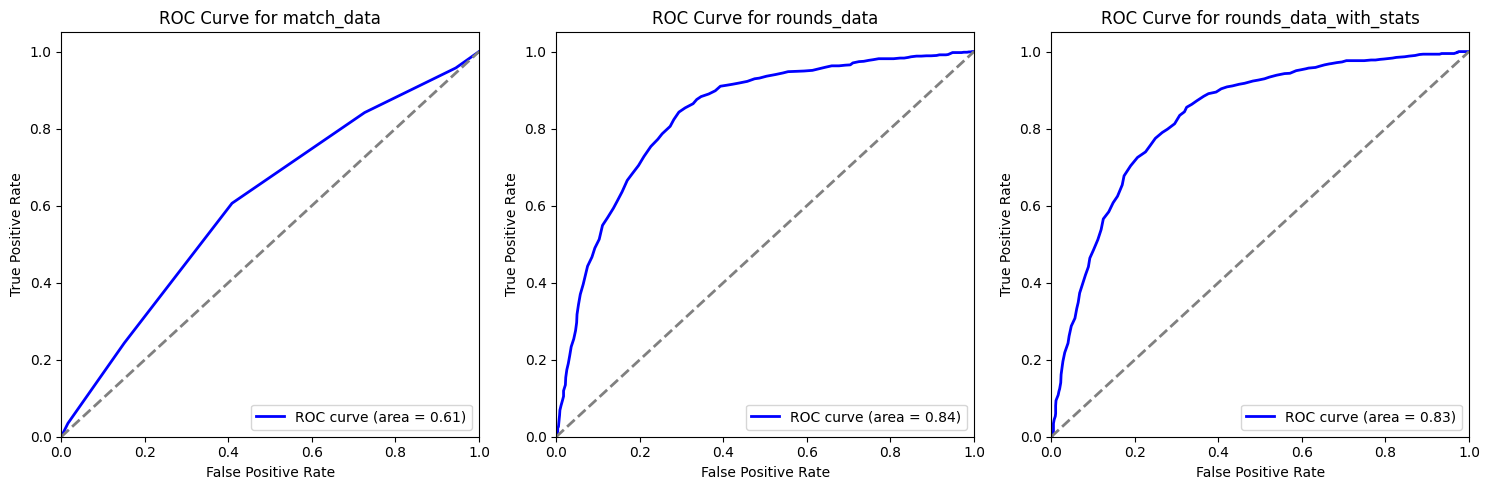

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, (X, y, ds_name, best_k) in enumerate(datasets):
    y = y.to_numpy()
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    knn = KNN(k=best_k)
    
    start_time = time()
    
    knn.fit(X_train, y_train)
    y_pred = np.array([knn.predict(x) for x in X_test])
    y_probs = np.array([knn.predict_probabilities(x) for x in X_test])

    print(f"Dataset: {ds_name} with best_k={best_k}")
    print(f"Time to fit and predict: {time() - start_time} seconds")
    
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:,1])}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
    
    axs[idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs[:,1]):.2f})')
    axs[idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[idx].set_xlim([0.0, 1.0])
    axs[idx].set_ylim([0.0, 1.05])
    axs[idx].set_xlabel('False Positive Rate')
    axs[idx].set_ylabel('True Positive Rate')
    axs[idx].set_title(f'ROC Curve for {ds_name}')
    axs[idx].legend(loc='lower right')

plt.tight_layout()
plt.show()